<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Helium_Mobius_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ζ=1.50  Singlet=-4.029365  Triplet=-5.695692
ζ=1.60  Singlet=-4.173640  Triplet=-5.950637
ζ=1.70  Singlet=-4.319541  Triplet=-6.205299
ζ=1.80  Singlet=-4.467165  Triplet=-6.459702
ζ=1.90  Singlet=-4.616585  Triplet=-6.713869
ζ=2.00  Singlet=-4.767845  Triplet=-6.967821


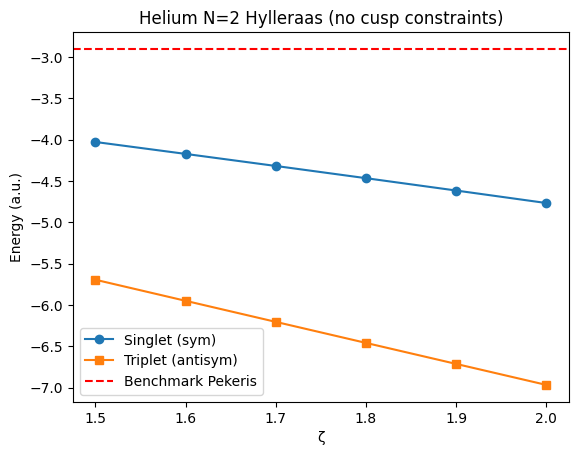


Summary:
Singlet min ≈ -4.767845
Triplet min ≈ -6.967821


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh
from numpy.polynomial.laguerre import laggauss

Z = 2.0

# ------------------------
# Perimetric coordinates
# ------------------------
def r_vars(u,v,w):
    r1 = 0.5*(v+w)
    r2 = 0.5*(u+w)
    r12= 0.5*(u+v)
    return r1,r2,r12

def J_per(u,v,w):
    return 0.125*u*v*w*(u+v)*(v+w)*(w+u)

def gauss_laguerre(n, scale=1.0):
    x, w = laggauss(n)
    return x/scale, w/scale

# ------------------------
# Hylleraas basis (N<=2)
# ------------------------
def hylleraas_indices(N=2):
    idx=[]
    for i in range(N+1):
        for j in range(N+1-i):
            for k in range(N+1-i-j):
                idx.append((i,j,k))
    return idx

def base_f(r1,r2,r12, ijk, zeta):
    i,j,k = ijk
    return (r1**i)*(r2**j)*(r12**k)*np.exp(-zeta*(r1+r2))

def phi_sym(r1,r2,r12, ijk, zeta):
    return (base_f(r1,r2,r12, ijk, zeta) + base_f(r2,r1,r12, ijk, zeta))/np.sqrt(2)

def phi_asym(r1,r2,r12, ijk, zeta):
    return (base_f(r1,r2,r12, ijk, zeta) - base_f(r2,r1,r12, ijk, zeta))/np.sqrt(2)

# ------------------------
# Analytic Laplacian
# ------------------------
def lap_base(r1,r2,r12, ijk, z):
    i,j,k = ijk
    f = base_f(r1,r2,r12, ijk, z)
    r1e,r2e,r12e = r1+1e-14, r2+1e-14, r12+1e-14
    # derivatives
    d2r1 = f*((i/r1e - z)**2 - i/(r1e**2))
    d2r2 = f*((j/r2e - z)**2 - j/(r2e**2))
    d2r12= f*(k*(k-1)/(r12e**2))
    dr1  = f*((i/r1e)-z)
    dr2  = f*((j/r2e)-z)
    dr12 = f*(k/r12e)
    d2r1r2   = f*((i/r1e - z)*(j/r2e - z))
    d2r1r12  = f*((i/r1e - z)*(k/r12e))
    d2r2r12  = f*((j/r2e - z)*(k/r12e))
    A=(r1e**2+r2e**2-r12e**2)/(r1e*r2e)
    B=(r1e**2+r12e**2-r2e**2)/(r1e*r12e)
    C=(r2e**2+r12e**2-r1e**2)/(r2e*r12e)
    lap=(d2r1+d2r2+(2/r1e)*dr1+(2/r2e)*dr2
         +2*(d2r12+(2/r12e)*dr12)
         +A*d2r1r2+B*d2r1r12+C*d2r2r12)
    return lap

def lap_sym(r1,r2,r12, ijk, z):
    return (lap_base(r1,r2,r12, ijk, z) + lap_base(r2,r1,r12,(ijk[1],ijk[0],ijk[2]),z))/np.sqrt(2)

def lap_asym(r1,r2,r12, ijk, z):
    return (lap_base(r1,r2,r12, ijk, z) - lap_base(r2,r1,r12,(ijk[1],ijk[0],ijk[2]),z))/np.sqrt(2)

# ------------------------
# Build matrices
# ------------------------
def build_mats(idx, zeta, sector="singlet", ngrid=20):
    K=len(idx)
    S=np.zeros((K,K)); H=np.zeros((K,K))
    u,wu=gauss_laguerre(ngrid); v,wv=gauss_laguerre(ngrid); w,ww=gauss_laguerre(ngrid)

    for a,ua in enumerate(u):
        for b,vb in enumerate(v):
            for c,wc in enumerate(w):
                r1,r2,r12=r_vars(ua,vb,wc)
                if r1<=0 or r2<=0 or r12<=0: continue
                wt=wu[a]*wv[b]*ww[c]*J_per(ua,vb,wc)
                if sector=="singlet":
                    Phi=np.array([phi_sym(r1,r2,r12,ijk,zeta) for ijk in idx])
                    Lap=np.array([lap_sym(r1,r2,r12,ijk,zeta) for ijk in idx])
                else:
                    Phi=np.array([phi_asym(r1,r2,r12,ijk,zeta) for ijk in idx])
                    Lap=np.array([lap_asym(r1,r2,r12,ijk,zeta) for ijk in idx])
                S+=wt*np.outer(Phi,Phi)
                V=-Z/r1 - Z/r2 + 1.0/r12
                H+=wt*V*np.outer(Phi,Phi)
                H+=wt*(-0.25)*(np.outer(Phi,Lap)+np.outer(Lap,Phi))
    return S,H

# ------------------------
# Solve generalized EVP with regularization
# ------------------------
def solve_gen(S,H,tol=1e-8):
    evals,evecs=eigh(S)
    keep=evals>tol
    Sinv2=evecs[:,keep] @ np.diag(1.0/np.sqrt(evals[keep])) @ evecs[:,keep].T
    Ht=Sinv2 @ H @ Sinv2
    E,U=eigh(Ht)
    return E

# ------------------------
# Run scan
# ------------------------
N=2; idx=hylleraas_indices(N)
zlist=np.linspace(1.5,2.0,6)
vals_s=[]; vals_t=[]
for z in zlist:
    S_s,H_s=build_mats(idx,z,"singlet",ngrid=24)
    S_t,H_t=build_mats(idx,z,"triplet",ngrid=24)
    E_s=solve_gen(S_s,H_s); E_t=solve_gen(S_t,H_t)
    vals_s.append(E_s[0]); vals_t.append(E_t[0])
    print(f"ζ={z:.2f}  Singlet={E_s[0]:.6f}  Triplet={E_t[0]:.6f}")

plt.plot(zlist,vals_s,"-o",label="Singlet (sym)")
plt.plot(zlist,vals_t,"-s",label="Triplet (antisym)")
plt.axhline(-2.903724,ls="--",c="r",label="Benchmark Pekeris")
plt.xlabel("ζ"); plt.ylabel("Energy (a.u.)")
plt.title("Helium N=2 Hylleraas (no cusp constraints)")
plt.legend(); plt.show()

print("\nSummary:")
print(f"Singlet min ≈ {np.min(vals_s):.6f}")
print(f"Triplet min ≈ {np.min(vals_t):.6f}")
